# *Project : predict "next_day_close" column*

# Import Libraries & Read Dataset

In [1]:
import requests

url = 'https://raw.githubusercontent.com/lko9911/Kaggle/master/Compare_Regression_models.py'

r = requests.get(url)

with open('Compare_Regression_models.py', 'w') as f:
    f.write(r.text)

In [2]:
# For Compare modeling
from Compare_Regression_models import evaluate_models

# For Standard data
from sklearn.preprocessing import StandardScaler

# For Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# For Evaluate model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# For EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('/kaggle/input/netflix-stock-price-with-indicators/nflx_2014_2023.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            2516 non-null   object 
 1   open            2516 non-null   float64
 2   high            2516 non-null   float64
 3   low             2516 non-null   float64
 4   close           2516 non-null   float64
 5   volume          2516 non-null   int64  
 6   rsi_7           2516 non-null   float64
 7   rsi_14          2516 non-null   float64
 8   cci_7           2516 non-null   float64
 9   cci_14          2516 non-null   float64
 10  sma_50          2516 non-null   float64
 11  ema_50          2516 non-null   float64
 12  sma_100         2516 non-null   float64
 13  ema_100         2516 non-null   float64
 14  macd            2516 non-null   float64
 15  bollinger       2516 non-null   float64
 16  TrueRange       2516 non-null   float64
 17  atr_7           2516 non-null   f

# Data Preprocessing

In [5]:
df.isna().sum()

date              0
open              0
high              0
low               0
close             0
volume            0
rsi_7             0
rsi_14            0
cci_7             0
cci_14            0
sma_50            0
ema_50            0
sma_100           0
ema_100           0
macd              0
bollinger         0
TrueRange         0
atr_7             0
atr_14            0
next_day_close    0
dtype: int64

In [6]:
df['date'] = pd.to_datetime(df['date'])

# Compare models 

In [7]:
X = df.drop(['date','next_day_close'], axis=1)
y = df['next_day_close']

evaluate_models(X,y)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e+04, tolerance: 6.921e+03
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 2516, number of used features: 18
[LightGBM] [Info] Start training from score 274.652630


,Model,RMSE,R2
0,Linear Regression,8.488588,0.997381
1,Ridge Regression,8.557244,0.997338
2,Lasso Regression,8.881817,0.997132
3,ElasticNet,16.130630,0.990541
4,Decision Tree Regressor,0.000000,1.000000
5,Random Forest Regressor,3.448269,0.999568
6,Support Vector Machine Regressor,46.025042,0.922993
7,K-Nearest Neighbors Regressor,10.528784,0.995970
8,Gradient Boosting Regressor,6.457155,0.998484
9,XGBoost Regressor,1.408403,0.999928


# XGBoost Modeling

> ## Find useful columns

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train, y_train)

feature_importances = rf_model.feature_importances_

sorted_indices = feature_importances.argsort()[::-1]

k = 10
selected_features = X.columns[sorted_indices][:k]

print("Selected Features:", selected_features)

Selected Features: Index(['close', 'low', 'high', 'open', 'bollinger', 'sma_50', 'ema_50',
       'sma_100', 'ema_100', 'volume'],
      dtype='object')


> ## Standardizing data

In [9]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

> ## XGboost's GridSearch

In [10]:
param_grid = {
    'n_estimators': [100,200,300,400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb_model = XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train_scaled, y_train)

Best parameters found:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Evaluating XGBoost Regressor

In [11]:
y_pred = best_xgb_model.predict(X_test_scaled)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("RMSE : ", round(rmse,5))
print("R2 Score:", round(r2,5))

RMSE :  9.16441
R2 Score: 0.99707


In [12]:
y_pred = best_xgb_model.predict(X_test_scaled)

comparison = pd.DataFrame({'actual': y_test, 'pred': y_pred})
comparison

,actual,pred
617,95.440002,95.482658
927,176.419998,178.678345
942,181.350006,181.010895
973,195.080002,192.872116
1968,662.919983,659.477173
...,...,...
51,60.012856,61.585583
1936,589.289978,601.313843
495,116.629997,122.355438
1506,329.089996,338.321289


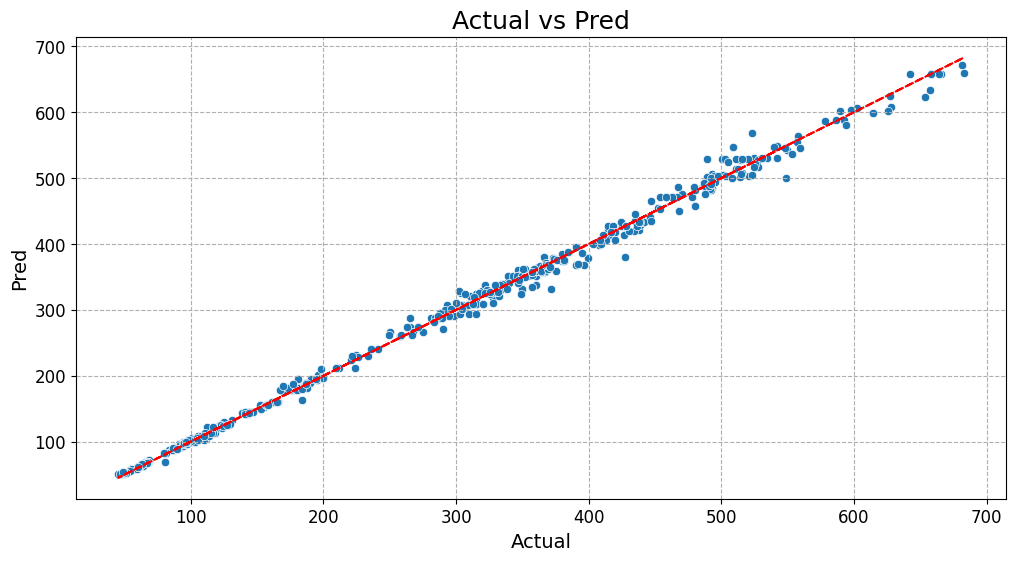

In [13]:
plt.figure(figsize=(12,6))

sns.scatterplot(x='actual', y='pred', data=comparison)
plt.plot(comparison['actual'], comparison['actual'], color='red', linestyle='--')
plt.title('Actual vs Pred', fontsize=18)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Pred', fontsize=14)
plt.xticks(rotation=0, fontsize=12)  
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.show()

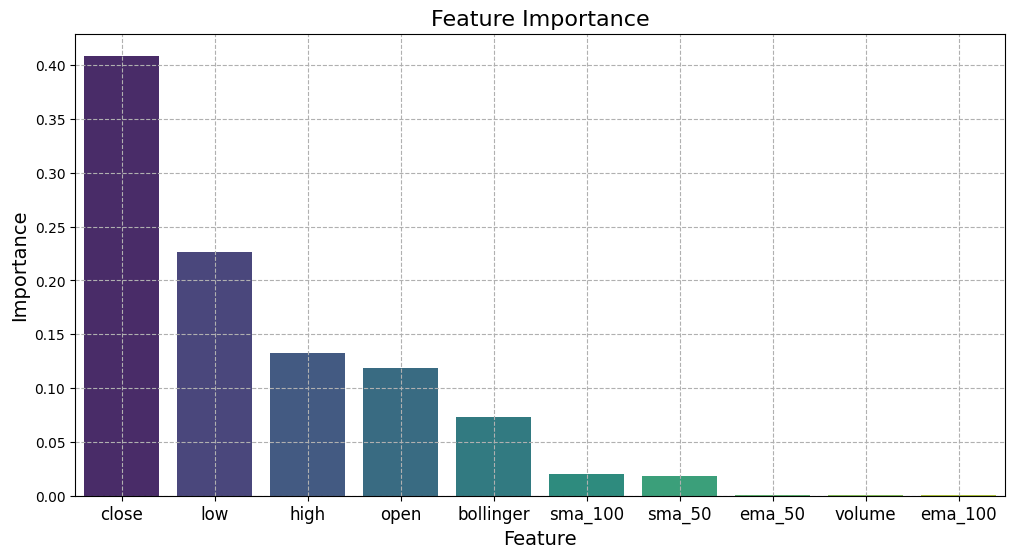

In [14]:
importances = best_xgb_model.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=[feature_names[i] for i in sorted_indices], y=importances[sorted_indices], palette="viridis")
plt.xticks(rotation=0, fontsize=12)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.title('Feature Importance', fontsize=16)
plt.grid(linestyle='--')
plt.show()

# Thanks